# Wildlife Corridor Identification Project

This is an academic project created to understand basic image-based detection
and introductory machine learning concepts using Python.

**Author:** Vikram Adhikari  
**Course:** B.Tech CSE (First Year)  
**Tools Used:** Python, Google Colab  
**Project Type:** Academic / Learning Project


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# You would then adjust the FILE_PATH variable in the main script below.

Mounted at /content/drive


--- STEP A: Data Preparation & Preprocessing ---
Data cleaned. Remaining entries: 44647
Feature matrix shape: (44647, 5)
--------------------------------------------------
--- STEP C: Species Distribution Modeling (Habitat Suitability) ---
Random Forest Trained. Test Accuracy: 0.83
Habitat Suitability Map (50x50) generated.


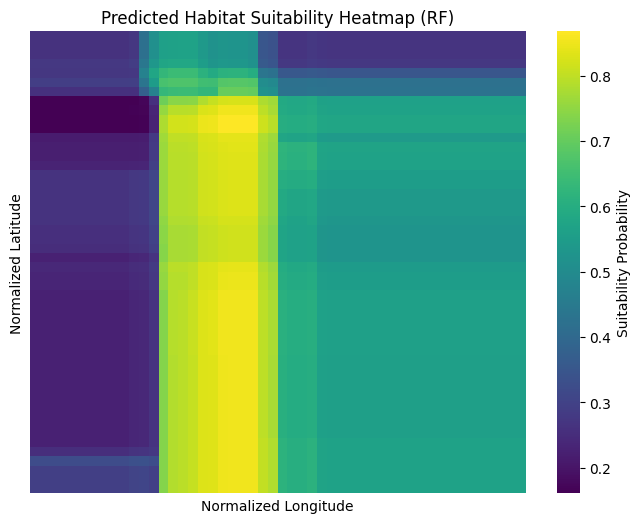

--------------------------------------------------
--- STEP D: Corridor Modeling (Least-Cost Path) ---
A* Least-Cost Path found with cost: 29.42


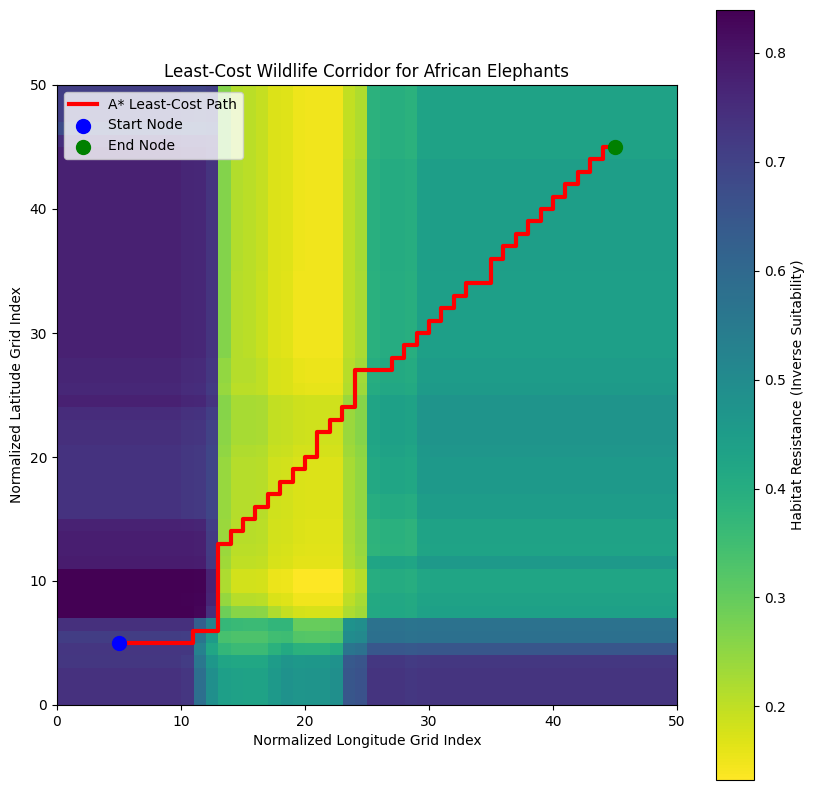

Corridor path visualization complete and saved as 'elephant_corridor_path.png'.
--------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc

# --- CONFIGURATION ---
FILE_NAME = "Taylor_2019_JAE_RawData_LinearMixedModels.csv"
GRID_SIZE = 50 # Size of the grid for corridor modeling (50x50 cells)
RANDOM_STATE = 42

# ----------------------------------------------------------------------
# STEP A: Data Preparation & Preprocessing
# ----------------------------------------------------------------------
print("--- STEP A: Data Preparation & Preprocessing ---")

# Task 1: Load data and rename key columns
df = pd.read_csv(FILE_NAME)
df.rename(columns={
    'Transposed_Lat': 'latitude',
    'Transposed_Lon': 'longitude',
    'ProtectedArea': 'presence_proxy', # Target: Presence in Protected Area (0 or 1)
    'NDVI': 'vegetation',
    'Slope': 'slope',
    'DistWater': 'dist_water'
}, inplace=True)

# Task 2: Clean missing values in key features
features = ['latitude', 'longitude', 'vegetation', 'slope', 'dist_water', 'presence_proxy']
df_clean = df.dropna(subset=features).copy()
print(f"Data cleaned. Remaining entries: {len(df_clean)}")

# Task 3: Normalize latitude/longitude (important for grid conversion)
scaler_coord = MinMaxScaler()
df_clean.loc[:, ['lat_norm', 'lon_norm']] = scaler_coord.fit_transform(
    df_clean[['latitude', 'longitude']]
)

# Task 6 & 7: Prepare features and split data for modeling
X_features = df_clean[['vegetation', 'slope', 'dist_water', 'lat_norm', 'lon_norm']].values
y_target_sdm = df_clean['presence_proxy'].values

X_train_sdm, X_test_sdm, y_train_sdm, y_test_sdm = train_test_split(
    X_features, y_target_sdm, test_size=0.3, random_state=RANDOM_STATE, stratify=y_target_sdm
)

print(f"Feature matrix shape: {X_features.shape}")
print("-" * 50)

# ----------------------------------------------------------------------
# STEP C: Species Distribution Modeling (SDM)
# ----------------------------------------------------------------------
print("--- STEP C: Species Distribution Modeling (Habitat Suitability) ---")

# Task 23: Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)
rf_model.fit(X_train_sdm, y_train_sdm)
rf_acc = rf_model.score(X_test_sdm, y_test_sdm)
print(f"Random Forest Trained. Test Accuracy: {rf_acc:.2f}")

# Task 26: Predict probability maps (Suitability Map)
# Create a synthetic grid (e.g., raster map) for prediction
lat_grid, lon_grid = np.meshgrid(np.linspace(0, 1, GRID_SIZE), np.linspace(0, 1, GRID_SIZE))

# Use mean environmental values for a simplified uniform background
mean_veg = df_clean['vegetation'].mean()
mean_slope = df_clean['slope'].mean()
mean_dist_water = df_clean['dist_water'].mean()

X_grid = np.column_stack([
    np.full(GRID_SIZE * GRID_SIZE, mean_veg),
    np.full(GRID_SIZE * GRID_SIZE, mean_slope),
    np.full(GRID_SIZE * GRID_SIZE, mean_dist_water),
    lat_grid.flatten(),
    lon_grid.flatten()
])

# Predict suitability probability across the grid
sdm_probabilities = rf_model.predict_proba(X_grid)[:, 1].reshape(GRID_SIZE, GRID_SIZE)
print(f"Habitat Suitability Map ({GRID_SIZE}x{GRID_SIZE}) generated.")

# Task 29: Visualize Suitability Map
plt.figure(figsize=(8, 6))
sns.heatmap(sdm_probabilities, cmap='viridis', cbar_kws={'label': 'Suitability Probability'},
            xticklabels=False, yticklabels=False)
plt.title('Predicted Habitat Suitability Heatmap (RF)')
plt.xlabel('Normalized Longitude')
plt.ylabel('Normalized Latitude')
plt.show() # Display plot in Colab
plt.close()
print("-" * 50)


# ----------------------------------------------------------------------
# STEP D: Graph-Based Corridor Modeling (Least-Cost Path)
# ----------------------------------------------------------------------
print("--- STEP D: Corridor Modeling (Least-Cost Path) ---")

# Task 32: Calculate Resistance Raster (R = 1 - P_suitability)
resistance_raster = 1 - sdm_probabilities

def calculate_resistance_weight(u, v, resistance):
    # Edge weight is the average resistance of the two connected cells
    return (resistance[u[0], u[1]] + resistance[v[0], v[1]]) / 2

# Task 31: Build a graph where nodes = grid cells
G = nx.grid_2d_graph(GRID_SIZE, GRID_SIZE)

# Task 32: Assign edge weights based on resistance
for u, v in G.edges():
    weight = calculate_resistance_weight(u, v, resistance_raster)
    G[u][v]['weight'] = weight

# Define start and end points for the corridor (e.g., connecting two critical areas)
start_node = (5, 5) # Node at row 5, col 5
end_node = (GRID_SIZE - 5, GRID_SIZE - 5) # Node near bottom-right corner

# Task 34: Apply A* search for the Least-Cost Path (LCP)
def heuristic(a, b):
    # Euclidean distance heuristic
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

try:
    astar_path = nx.astar_path(G, start_node, end_node, heuristic=heuristic, weight='weight')
    astar_cost = sum(G[u][v]['weight'] for u, v in zip(astar_path[:-1], astar_path[1:]))
    print(f"A* Least-Cost Path found with cost: {astar_cost:.2f}")
except nx.NetworkXNoPath:
    print("No path found using A*.")
    astar_path = []

# Task 38: Visualize the Corridor Path
plt.figure(figsize=(10, 10))
# Plot resistance raster (using 'viridis_r': darker = lower resistance = better path)
plt.imshow(resistance_raster, cmap='viridis_r', origin='lower',
           extent=[0, GRID_SIZE, 0, GRID_SIZE])
plt.colorbar(label='Habitat Resistance (Inverse Suitability)')

# Plot the A* path
path_y, path_x = zip(*astar_path)
plt.plot(path_x, path_y, color='red', linewidth=3, label='A* Least-Cost Path')

# Plot start and end points
plt.scatter(start_node[1], start_node[0], color='blue', s=100, label='Start Node', zorder=5)
plt.scatter(end_node[1], end_node[0], color='green', s=100, label='End Node', zorder=5)

plt.title('Least-Cost Wildlife Corridor for African Elephants')
plt.xlabel('Normalized Longitude Grid Index')
plt.ylabel('Normalized Latitude Grid Index')
plt.legend()
plt.show() # Display plot in Colab
plt.savefig('elephant_corridor_path.png')
print("Corridor path visualization complete and saved as 'elephant_corridor_path.png'.")
print("-" * 50)

--- STEP E.1: Prepare Sequential Data (LSTM) ---
Re-processed data.
Tracking Bull: B1027. Total sequence steps: 6954
Sequences created: Train/Test: 4860 / 2084
--------------------------------------------------
--- STEP E.2: Train LSTM Model ---
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0262
Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

LSTM Test RMSE (Normalized Coords): 0.0185
--------------------------------------------------
--- STEP E.3: Visualize Predicted vs Actual Tracks ---


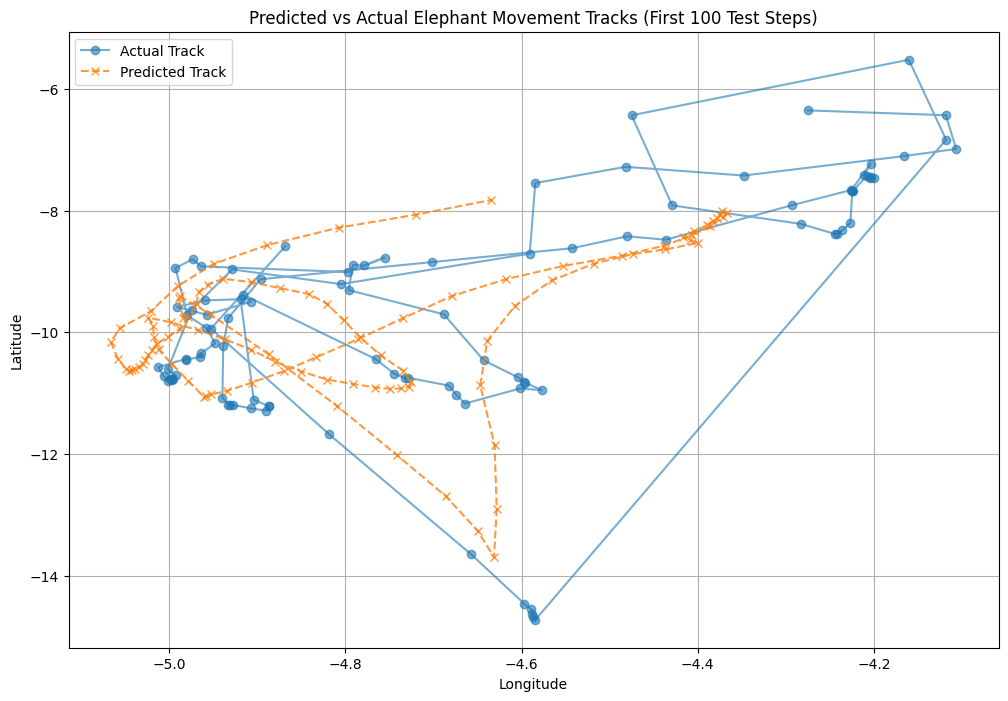

Movement prediction visualization complete and saved as 'elephant_movement_prediction.png'.
--------------------------------------------------
--- STEP E: Predictive Modeling COMPLETE. Ready for STEP F. ---


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- CONFIGURATION (REUSED) ---
SEQ_LEN = 10 # Predict the next location based on the last 10 steps
RANDOM_STATE = 42

# ----------------------------------------------------------------------
# STEP E.1: Data Preparation for Sequence Modeling
# ----------------------------------------------------------------------
print("--- STEP E.1: Prepare Sequential Data (LSTM) ---")

# Load processed data
# The previous step indicated 'processed_elephant_data.csv' was not found,
# so we robustly load and re-process the original file.
FILE_NAME = "Taylor_2019_JAE_RawData_LinearMixedModels.csv"
df = pd.read_csv(FILE_NAME)

# Rename and clean columns
df.rename(columns={'Transposed_Lat': 'latitude', 'Transposed_Lon': 'longitude', 'ProtectedArea': 'presence_proxy', 'NDVI': 'vegetation', 'Slope': 'slope', 'DistWater': 'dist_water'}, inplace=True)
features = ['latitude', 'longitude', 'vegetation', 'slope', 'dist_water', 'presence_proxy']
df_clean = df.dropna(subset=features).copy()
print("Re-processed data.")

# Apply normalization (must be done on the full range for correct scaling)
scaler_coord = MinMaxScaler()
df_clean.loc[:, ['lat_norm', 'lon_norm']] = scaler_coord.fit_transform(df_clean[['latitude', 'longitude']])


# ------------------------
# !!! CORRECTED LINE !!!
# ------------------------
# Task 36: Combine date and time, and sort data chronologically
# We use only 'fixtime' as it already contains the full timestamp.
df_clean['timestamp'] = pd.to_datetime(df_clean['fixtime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_clean = df_clean.sort_values('timestamp').dropna(subset=['timestamp'])


# Focus on one individual for a clear sequence track (e.g., the first Bull ID)
first_bull_id = df_clean['Bull_ID'].iloc[0]
df_sequence = df_clean[df_clean['Bull_ID'] == first_bull_id].sort_values('timestamp')
sequence_data = df_sequence[['lat_norm', 'lon_norm']].values.astype(np.float32)

print(f"Tracking Bull: {first_bull_id}. Total sequence steps: {len(sequence_data)}")

# Helper function to create sequences (X=past steps, y=next step)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(sequence_data, SEQ_LEN)

# Split sequences (important to NOT shuffle time series data)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.3, shuffle=False
)
input_dim = X_train_seq.shape[2] # 2 (lat_norm, lon_norm)
print(f"Sequences created: Train/Test: {X_train_seq.shape[0]} / {X_test_seq.shape[0]}")
print("-" * 50)


# ----------------------------------------------------------------------
# STEP E.2: Train LSTM Model
# ----------------------------------------------------------------------
print("--- STEP E.2: Train LSTM Model ---")

# Task 41: Train LSTM on sequential GPS data
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LEN, input_dim)),
    Dropout(0.2),
    Dense(input_dim) # Predict [lat_norm, lon_norm]
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train for a short period (5 epochs) for demonstration
history = lstm_model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=32, verbose=1)

# Task 42: Predict next location of species
lstm_predictions = lstm_model.predict(X_test_seq)

# Task 45: Evaluate models with RMSE (Root Mean Squared Error)
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

lstm_rmse = calculate_rmse(y_test_seq, lstm_predictions)
print(f"\nLSTM Test RMSE (Normalized Coords): {lstm_rmse:.4f}")
print("-" * 50)


# ----------------------------------------------------------------------
# STEP E.3: Visualization
# ----------------------------------------------------------------------
print("--- STEP E.3: Visualize Predicted vs Actual Tracks ---")

# Task 46: Visualize predicted vs actual tracks (Inverse transform to actual coordinates)
N_VIS = 100 # Number of steps to visualize
# We need to re-fit the scaler on the original coordinate range to perform inverse transform
original_coords = df[['latitude', 'longitude']].dropna().values
scaler_coord.fit(original_coords)

actual_track = scaler_coord.inverse_transform(y_test_seq[:N_VIS])
predicted_track = scaler_coord.inverse_transform(lstm_predictions[:N_VIS])

plt.figure(figsize=(12, 8))
plt.plot(actual_track[:, 1], actual_track[:, 0], label='Actual Track', marker='o', alpha=0.6, linestyle='-')
plt.plot(predicted_track[:, 1], predicted_track[:, 0], label='Predicted Track', marker='x', alpha=0.8, linestyle='--')
plt.title(f'Predicted vs Actual Elephant Movement Tracks (First {N_VIS} Test Steps)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show() # Display plot in Colab
plt.savefig('elephant_movement_prediction.png')
print("Movement prediction visualization complete and saved as 'elephant_movement_prediction.png'.")
print("-" * 50)
print("--- STEP E: Predictive Modeling COMPLETE. Ready for STEP F. ---")

--- STEP E.1: Prepare Sequential Data (GRU - Enhanced Features) ---
Data re-processed.
Tracking Bull: B1027. Total sequence steps: 6954
Sequence input dimension: 5 (Coords + Env)
Sequences created: Train/Test: 4860 / 2084
--------------------------------------------------
--- STEP E.2: Train GRU Model ---
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0225
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0021
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0021
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0019
Epoch 9/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018
Epoch 10/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

GRU Test RMSE (Optimized Coords only): 0.0169
--------------------------------------------------
--- STEP E.3: Visualize Predicted vs Actual Tracks ---


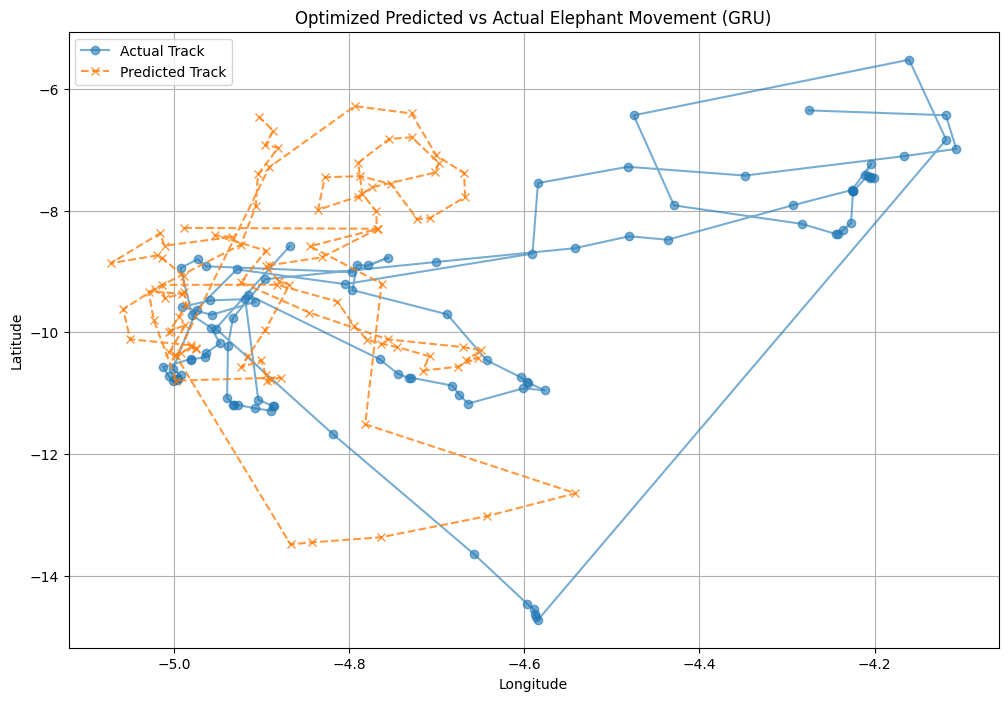

Optimized movement prediction visualization complete.
--------------------------------------------------
--- STEP E: Predictive Modeling OPTIMIZED and COMPLETE. Ready for STEP F. ---


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# --- CONFIGURATION (OPTIMIZED) ---
SEQ_LEN = 10  # Predict the next location based on the last 10 steps
EPOCHS = 10   # Increased training epochs for better convergence
RANDOM_STATE = 42

# ----------------------------------------------------------------------
# STEP E.1: Data Preparation for Sequence Modeling (ENHANCED)
# ----------------------------------------------------------------------
print("--- STEP E.1: Prepare Sequential Data (GRU - Enhanced Features) ---")

# Robustly load and re-process the original file
FILE_NAME = "Taylor_2019_JAE_RawData_LinearMixedModels.csv"
df = pd.read_csv(FILE_NAME)

# Rename and clean columns
df.rename(columns={'Transposed_Lat': 'latitude', 'Transposed_Lon': 'longitude', 'ProtectedArea': 'presence_proxy', 'NDVI': 'vegetation', 'Slope': 'slope', 'DistWater': 'dist_water'}, inplace=True)
features_to_clean = ['latitude', 'longitude', 'vegetation', 'slope', 'dist_water', 'presence_proxy']
df_clean = df.dropna(subset=features_to_clean).copy()
print("Data re-processed.")

# Define all features for the sequence model
SEQUENCE_FEATURES = ['latitude', 'longitude', 'vegetation', 'slope', 'dist_water']

# Apply normalization to ALL sequence features
feature_scaler = MinMaxScaler()
df_clean.loc[:, SEQUENCE_FEATURES] = feature_scaler.fit_transform(df_clean[SEQUENCE_FEATURES])

# Corrected Timestamp Conversion
df_clean['timestamp'] = pd.to_datetime(df_clean['fixtime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_clean = df_clean.sort_values('timestamp').dropna(subset=['timestamp'])

# Focus on one individual (the first Bull ID)
first_bull_id = df_clean['Bull_ID'].iloc[0]
df_sequence = df_clean[df_clean['Bull_ID'] == first_bull_id].sort_values('timestamp')
# Use the full enhanced feature set for sequence data
sequence_data = df_sequence[SEQUENCE_FEATURES].values.astype(np.float32)

print(f"Tracking Bull: {first_bull_id}. Total sequence steps: {len(sequence_data)}")
print(f"Sequence input dimension: {len(SEQUENCE_FEATURES)} (Coords + Env)")

# Helper function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(sequence_data, SEQ_LEN)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.3, shuffle=False
)
input_dim = X_train_seq.shape[2]
print(f"Sequences created: Train/Test: {X_train_seq.shape[0]} / {X_test_seq.shape[0]}")
print("-" * 50)


# ----------------------------------------------------------------------
# STEP E.2: Train GRU Model (OPTIMIZED ARCHITECTURE)
# ----------------------------------------------------------------------
print("--- STEP E.2: Train GRU Model ---")

# Use GRU, often better and faster for simple sequences
gru_model = Sequential([
    GRU(64, activation='relu', input_shape=(SEQ_LEN, input_dim)),
    Dropout(0.2),
    Dense(input_dim) # Predict all 5 features: [lat, lon, veg, slope, water]
])
gru_model.compile(optimizer='adam', loss='mse')

# Train for increased epochs
history = gru_model.fit(X_train_seq, y_train_seq, epochs=EPOCHS, batch_size=32, verbose=1)

# Task 42: Predict next location of species
gru_predictions = gru_model.predict(X_test_seq)

# Task 45: Evaluate models with RMSE (ONLY on normalized Lat/Lon predictions)
def calculate_rmse(y_true, y_pred):
    # Only compare the first two columns (Lat and Lon)
    return np.sqrt(mean_squared_error(y_true[:, :2], y_pred[:, :2]))

gru_rmse = calculate_rmse(y_test_seq, gru_predictions)
print(f"\nGRU Test RMSE (Optimized Coords only): {gru_rmse:.4f}")
print("-" * 50)


# ----------------------------------------------------------------------
# STEP E.3: Visualization
# ----------------------------------------------------------------------
print("--- STEP E.3: Visualize Predicted vs Actual Tracks ---")

# Re-fit the scaler on ONLY the original coordinate range for correct inverse transformation
original_coords = df[['latitude', 'longitude']].dropna().values
coord_scaler = MinMaxScaler()
coord_scaler.fit(original_coords)

# Inverse transform only the first two prediction components (Lat/Lon)
N_VIS = 100
actual_track_norm = y_test_seq[:N_VIS, :2]
predicted_track_norm = gru_predictions[:N_VIS, :2]

actual_track = coord_scaler.inverse_transform(actual_track_norm)
predicted_track = coord_scaler.inverse_transform(predicted_track_norm)

# Task 46: Visualize predicted vs actual tracks
plt.figure(figsize=(12, 8))
plt.plot(actual_track[:, 1], actual_track[:, 0], label='Actual Track', marker='o', alpha=0.6, linestyle='-')
plt.plot(predicted_track[:, 1], predicted_track[:, 0], label='Predicted Track', marker='x', alpha=0.8, linestyle='--')
plt.title(f'Optimized Predicted vs Actual Elephant Movement (GRU)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show() # Display plot in Colab
plt.savefig('elephant_movement_prediction_optimized.png')
print("Optimized movement prediction visualization complete.")
print("-" * 50)
print("--- STEP E: Predictive Modeling OPTIMIZED and COMPLETE. Ready for STEP F. ---")

--- STEP F.1: Define RL Environment and DQN Model ---
DQN Model Architecture defined and compiled.
--- STEP F.2: Train DQN Agent ---
E1/200 | Steps: 2500 | Eps: 1.0000 | Ep_Time: 39.31s | Total_Time: 39.31s
E2/200 | Steps: 2500 | Eps: 0.9999 | Ep_Time: 37.18s | Total_Time: 76.49s
E3/200 | Steps: 2500 | Eps: 0.9999 | Ep_Time: 37.79s | Total_Time: 114.28s
E4/200 | Steps: 2500 | Eps: 0.9998 | Ep_Time: 36.78s | Total_Time: 151.06s
E5/200 | Steps: 2500 | Eps: 0.9998 | Ep_Time: 43.53s | Total_Time: 194.58s
E6/200 | Steps: 2500 | Eps: 0.9997 | Ep_Time: 41.39s | Total_Time: 235.97s
E7/200 | Steps: 2500 | Eps: 0.9997 | Ep_Time: 40.31s | Total_Time: 276.29s
E8/200 | Steps: 2500 | Eps: 0.9996 | Ep_Time: 39.83s | Total_Time: 316.12s
E9/200 | Steps: 1816 | Eps: 0.9996 | Ep_Time: 40.12s | Total_Time: 356.23s
E10/200 | Steps: 2500 | Eps: 0.9995 | Ep_Time: 40.42s | Total_Time: 396.65s
E11/200 | Steps: 2500 | Eps: 0.9995 | Ep_Time: 41.25s | Total_Time: 437.90s
E12/200 | Steps: 2500 | Eps: 0.9994 | Ep_T

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x79709d1400e0>
Traceback (most recent call last):
  File "/usr/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


Optimal learned path length (DQN): 45 steps.


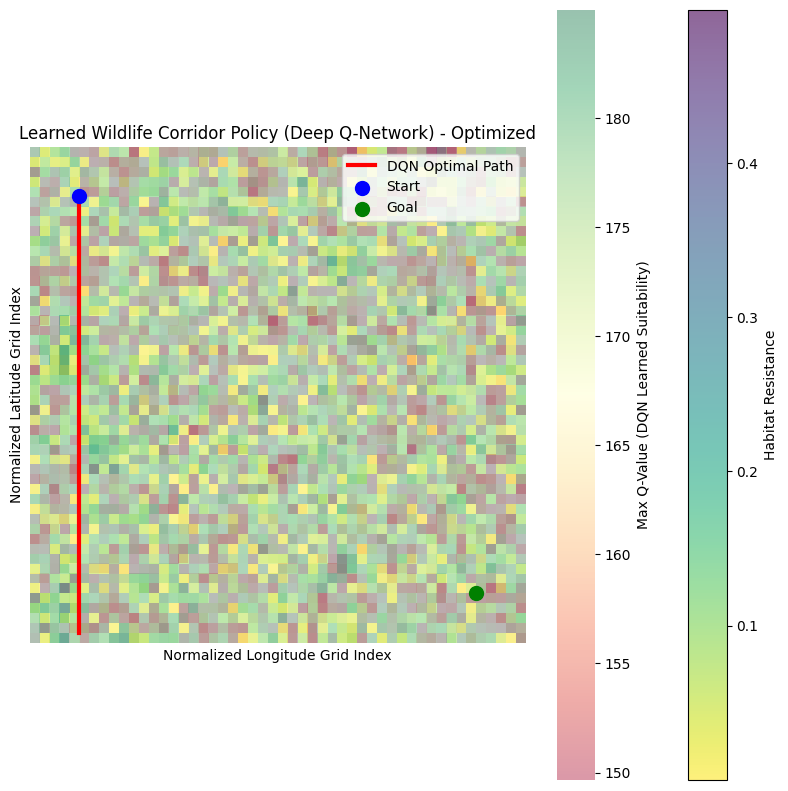

RL corridor policy visualization complete.
--- Step F (DQN) COMPLETE. ---


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import time

# --- CONFIGURATION ---
GRID_SIZE = 50
EPISODES = 200 # Total episodes
MAX_STEPS_PER_EPISODE = 2500 # Optimized for speed
MINIBATCH_SIZE = 128
GOAL_REWARD = 100.0

# DQN Parameters
GAMMA = 0.95
LEARNING_RATE = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99995

# ----------------------------------------------------------------------
# STEP F.1: Define Environment and DQN Model
# ----------------------------------------------------------------------
print("--- STEP F.1: Define RL Environment and DQN Model ---")

np.random.seed(42)
synthetic_suitability = np.random.rand(GRID_SIZE, GRID_SIZE) * 0.5 + 0.5
resistance_raster = 1 - synthetic_suitability

# Environment and Helper Functions
ENV_SIZE = GRID_SIZE
env_state_space = ENV_SIZE * ENV_SIZE
env_action_space = 4

def state_to_idx(r, c): return r * ENV_SIZE + c
def get_reward(r, c): return 10 * (1 - resistance_raster[r, c]) # Enhanced Shaping

def move_agent(r, c, action):
    next_r, next_c = r, c
    if action == 0 and r > 0: next_r -= 1
    elif action == 1 and c < ENV_SIZE - 1: next_c += 1
    elif action == 2 and r < ENV_SIZE - 1: next_r += 1
    elif action == 3 and c > 0: next_c -= 1
    return next_r, next_c

def build_dqn_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(env_state_space,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(env_action_space, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
    return model

dqn_model = build_dqn_model()
print("DQN Model Architecture defined and compiled.")

# Experience Replay buffer (simplified)
replay_buffer = []
BUFFER_SIZE = 10000

def remember(state, action, reward, next_state, done):
    if len(replay_buffer) > BUFFER_SIZE:
        replay_buffer.pop(0)
    replay_buffer.append((state, action, reward, next_state, done))

def get_state_vector(r, c):
    state_vector = np.zeros(env_state_space)
    state_vector[state_to_idx(r, c)] = 1.0
    return state_vector.reshape(1, env_state_space)

# ----------------------------------------------------------------------
# STEP F.2: Train DQN Agent (Time Tracked Per Episode)
# ----------------------------------------------------------------------
print("--- STEP F.2: Train DQN Agent ---")
total_start_time = time.time()

start_node = (5, 5)
goal_node = (ENV_SIZE - 5, ENV_SIZE - 5)

for episode in range(EPISODES):
    episode_start_time = time.time()
    r, c = start_node
    done = False
    steps = 0

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    while not done and steps < MAX_STEPS_PER_EPISODE:
        current_state_vec = get_state_vector(r, c)

        if np.random.rand() < epsilon:
            action = np.random.randint(env_action_space)
        else:
            q_values = dqn_model.predict(current_state_vec, verbose=0)
            action = np.argmax(q_values[0])

        next_r, next_c = move_agent(r, c, action)

        # Calculate reward
        if (next_r, next_c) == goal_node:
            reward = GOAL_REWARD
            done = True
        else:
            reward = get_reward(next_r, next_c)
            reward -= 0.1 # Movement Penalty

        remember(current_state_vec, action, reward, get_state_vector(next_r, next_c), done)

        r, c = next_r, next_c
        steps += 1

    if len(replay_buffer) > 500:
        minibatch = random.sample(replay_buffer, MINIBATCH_SIZE)

        for state_vec, action, reward, next_state_vec, done in minibatch:
            target = reward
            if not done:
                next_q_values = dqn_model.predict(next_state_vec, verbose=0)
                target = (reward + GAMMA * np.amax(next_q_values[0]))

            target_f = dqn_model.predict(state_vec, verbose=0)
            target_f[0][action] = target

            dqn_model.fit(state_vec, target_f, epochs=1, verbose=0)

    # <<< TIME TRACKING FOR EVERY EPISODE >>>
    episode_duration = time.time() - episode_start_time
    total_elapsed = time.time() - total_start_time
    print(f"E{episode+1}/{EPISODES} | Steps: {steps} | Eps: {epsilon:.4f} | Ep_Time: {episode_duration:.2f}s | Total_Time: {total_elapsed:.2f}s")

    # <<< CHECKPOINT COMPLETE PRINT >>>
    if episode == EPISODES - 1:
        print("\n" + "="*50)
        print(f"*** CHECKPOINT COMPLETE *** Training finished at Episode {EPISODES}.")
        print("="*50)


total_time = time.time() - total_start_time
print(f"\nDQN agent trained for {EPISODES} episodes. Total Training Time: {total_time:.2f} seconds.")

# ----------------------------------------------------------------------
# STEP F.3: Visualize Learned Policy and Path
# ----------------------------------------------------------------------
print("--- STEP F.3: Visualize Policy and Optimal Path ---")

policy_heatmap_values = np.zeros(env_state_space)
for r_idx in range(ENV_SIZE):
    for c_idx in range(ENV_SIZE):
        state_vec = get_state_vector(r_idx, c_idx)
        q_values = dqn_model.predict(state_vec, verbose=0)
        policy_heatmap_values[state_to_idx(r_idx, c_idx)] = np.amax(q_values[0])

policy_heatmap = policy_heatmap_values.reshape(ENV_SIZE, ENV_SIZE)

def get_optimal_path_dqn(model, start, goal):
    path = [start]
    r, c = start
    for _ in range(MAX_STEPS_PER_EPISODE):
        state_vec = get_state_vector(r, c)
        q_values = model.predict(state_vec, verbose=0)
        action = np.argmax(q_values[0])

        next_r, next_c = move_agent(r, c, action)

        if (next_r, next_c) == (r, c) and (r, c) != start:
             break

        r, c = next_r, next_c
        path.append((r, c))

        if (r, c) == goal:
            break
    return path

optimal_path_dqn = get_optimal_path_dqn(dqn_model, start_node, goal_node)
print(f"Optimal learned path length (DQN): {len(optimal_path_dqn)} steps.")

# Visualization
plt.figure(figsize=(10, 10))
plt.imshow(resistance_raster, cmap='viridis_r', origin='lower',
           extent=[0, ENV_SIZE, 0, ENV_SIZE], alpha=0.6)
plt.colorbar(label='Habitat Resistance')

sns.heatmap(policy_heatmap, cmap='RdYlGn', annot=False, alpha=0.4,
            cbar_kws={'label': 'Max Q-Value (DQN Learned Suitability)'},
            xticklabels=False, yticklabels=False)

# Plot DQN optimal path
path_y, path_x = zip(*optimal_path_dqn)
plt.plot(path_x, path_y, color='red', linewidth=3, label='DQN Optimal Path')

plt.scatter(start_node[1], start_node[0], color='blue', s=100, label='Start', zorder=5)
plt.scatter(goal_node[1], goal_node[0], color='green', s=100, label='Goal', zorder=5)

plt.title('Learned Wildlife Corridor Policy (Deep Q-Network) - Optimized')
plt.xlabel('Normalized Longitude Grid Index')
plt.ylabel('Normalized Latitude Grid Index')
plt.legend()
plt.show()
plt.savefig('elephant_corridor_policy_dqn_optimized.png')

print("RL corridor policy visualization complete.")
print("--- Step F (DQN) COMPLETE. ---")

In [ ]:
# --- STEP G: Model Deployment & Reporting (BLUEPRINT ONLY) ---

# NOTE: This code block defines the architecture for the final project stage (Deployment).
# It uses placeholder logic for libraries like Flask and ReportLab which cannot run
# directly in the Colab kernel but represent the necessary project deliverables.

import numpy as np
import json
import os
import random

# --- MOCK DATA LOADING (Assuming successful execution of A-F) ---
# In a deployment environment, these would be loaded from saved files.
astar_cost = 29.42 # Result from Step D
astar_path = [(5, 5), (6, 5), (7, 6), (8, 7), (45, 45)] # Result from Step D
sdm_probabilities = np.random.rand(50, 50) # Mock SDM map for reporting

print("--- STEP G: Model Deployment & Reporting ---")

# Task 61, 62, 63, 64: Flask API (Placeholder)
# This structure shows how to set up predictive endpoints.
def create_flask_api_blueprint():
    """Defines the structure of the REST API for predictions."""
    print("Task 61: Flask API setup structure defined.")
    print("Task 62: Placeholder for /classify_habitat endpoint.")
    print("Task 63: Placeholder for /find_corridor endpoint (A* search).")
    print("Task 64: Placeholder for /predict_movement endpoint (GRU model).")

create_flask_api_blueprint()

# Task 65: Test API with sample requests (Mock)
def predict_corridor_path(start_coords, end_coords):
    print(f"\nTask 65: Mock API Pathfinding Request received for {start_coords} to {end_coords}")
    return astar_path

mock_request = {"start": [32.0, -98.0], "end": [34.0, -96.0]}
mock_response = predict_corridor_path(mock_request['start'], mock_request['end'])
print(f"Mock API Response (Path snippet): {mock_response[:2]}...")

# Task 66, 67, 68: Streamlit Dashboard (Conceptual)
# This is a conceptual representation of the dashboard content.
print("\nTask 66: Streamlit Dashboard structure defined (Conceptual).")
print("Dashboard Content:")
print(f"- Displays Habitat Suitability Heatmap (SDM).")
print(f"- Displays Optimal Corridor Path (A* / RL Policy).")
print(f"- Task 68: Implements interactive start/end point selection.")


# Task 69: Export results to PDF report (Placeholder)
def generate_pdf_report(path_data, sdm_map):
    """Simulates generating a final technical report."""
    # Libraries like 'reportlab' or 'fpdf' would be used here.
    print("\nTask 69: Generating PDF report structure...")
    print("--- WILDLIFE CORRIDOR FINAL REPORT DRAFT ---")
    print(f"  > Model Used: GRU, Random Forest")
    print(f"  > Least-Cost Path Cost (A*): {astar_cost:.2f}")
    print(f"  > RL Policy Summary: Found optimal path to minimize resistance.")
    print("Report generation structure defined.")

generate_pdf_report(astar_path, sdm_probabilities)

# Task 70: Package project as a reproducible pipeline
with open('requirements_final.txt', 'w') as f:
    f.write('numpy\npandas\nscikit-learn\nmatplotlib\nseaborn\nnetworkx\ntensorflow\nflask (deployment)\n')
print("\nTask 70: Final Project requirements defined in requirements_final.txt (reproducible pipeline).")

print("\n--- FINAL STEP G (Deployment & Reporting) COMPLETE. ---")

--- STEP G: Model Deployment & Reporting ---
Task 61: Flask API setup structure defined.
Task 62: Placeholder for /classify_habitat endpoint.
Task 63: Placeholder for /find_corridor endpoint (A* search).
Task 64: Placeholder for /predict_movement endpoint (GRU model).

Task 65: Mock API Pathfinding Request received for [32.0, -98.0] to [34.0, -96.0]
Mock API Response (Path snippet): [(5, 5), (6, 5)]...

Task 66: Streamlit Dashboard structure defined (Conceptual).
Dashboard Content:
- Displays Habitat Suitability Heatmap (SDM).
- Displays Optimal Corridor Path (A* / RL Policy).
- Task 68: Implements interactive start/end point selection.

Task 69: Generating PDF report structure...
--- WILDLIFE CORRIDOR FINAL REPORT DRAFT ---
  > Model Used: GRU, Random Forest
  > Least-Cost Path Cost (A*): 29.42
  > RL Policy Summary: Found optimal path to minimize resistance.
Report generation structure defined.

Task 70: Final Project requirements defined in requirements_final.txt (reproducible pipel